In [1]:
import torch
import sys
import glob
sys.path.append('../DabbaMu-DEEP-TFM/aim2')
project_dir='/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2'


In [43]:
#from adversarial_learning.swinIRwforward_support_files.models_define import swinIR_generative_decoder
#B_re
#exp_path= glob.glob('../exp_data_from_cluster/B_re/*/*/*/save_special')[0]
#other_opt_dir= 'adversarial_learning/swinIRwforward_support_files/opt.yaml' 

from adversarial_learning.swinIRwCustomUpwforward_support_files.models_define import swinIR_generative_decoder
#A_re2
exp_path= glob.glob('../exp_data_from_cluster/A_re2/*/*/*/save_special')[0]
other_opt_dir= 'adversarial_learning/swinIRwCustomUpwforward_support_files/opt.yaml'



In [5]:
exp_path_img64= '/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2/figs/baselineF/name(bbbcHumanMCF7cellsW4)@rotation_lambda(10000.0)@lambda_scale_factor(4)@T(4)@lr_H(1.0)@img_size(64)@num_samples_train(3000)@batch_size_train(32)/save_special'
exp_path_img256= '/home/udith/udith_works/DabbaMu-DEEP-TFM/aim2/figs/baselineF/name(bbbcHumanMCF7cellsW4)@rotation_lambda(10000.0)@lambda_scale_factor(4)@T(4)@lr_H(1.0)@img_size(256)@num_samples_train(3000)@batch_size_train(32)/save_special'


In [17]:
exp_path= exp_path_img256

model_dir= f'{exp_path}/latest_model.pth'
model_info= torch.load(model_dir)
cfg= model_info['cfg']

decoder_upsample_state_dict= model_info['decoder_upsample']
decoder_state_dict= model_info['decoder']
model_H_state_dict= model_info['model_H']
m = model_info['m']
epoch = model_info['epoch']

In [18]:
import sys
sys.path.append('../')

import torch
import glob
from torch import nn
import shutil
import os
from contextlib import redirect_stdout
from defaults import get_cfg_defaults

from modules.models.preprocess_H_weights import * #ifft_2d_with_fftshift_real
from modules.custom_activations import sigmoid_custom
from modules.kernels import *

from modules.datasets import *
from modules.data_utils import return_dataloaders

from modules.train_utils.segmentation import train

from modules.models.forward_model import modelA_class
from modules.models.forward_H import modelH_class
from modules.models.decoder import *
from modules.models.decoder_upsampling_nets import *
from modules.models.decoder_upsampling_nets_experimental import *
from modules.models.decoder_support_blocks import conv_bn_block
from modules.m_inc_procs import *

from modules.models.lambdat_yt_skips import *

#general params
torch_seed= cfg.GENERAL.torch_seed
device = cfg.GENERAL.device
save_dir= cfg.GENERAL.save_dir

#dataset params
get_dataset_func= eval(cfg.DATASET.name)
img_size= cfg.DATASET.img_size
num_samples_train= cfg.DATASET.num_samples_train
delta=cfg.DATASET.delta
batch_size_train= cfg.DATASET.batch_size_train
img_channels= cfg.DATASET.img_channels

# train params:
epochs=cfg.TRAIN.epochs
m_inc_proc =  eval(cfg.TRAIN.m_inc_proc)
show_results_epoch= cfg.TRAIN.show_results_epoch
train_model_iter= cfg.TRAIN.train_model_iter
train_H_iter= cfg.TRAIN.train_H_iter
criterion= eval(cfg.TRAIN.criterion) # defined below after defining models
classifier=cfg.TRAIN.classifier
rescale_for_classifier=cfg.TRAIN.rescale_for_classifier

## params to H:
T= cfg.MODEL.MODEL_H.T
H_weight_preprocess= eval(cfg.MODEL.MODEL_H.H_weight_preprocess)
H_init = cfg.MODEL.MODEL_H.H_init
initialization_bias= cfg.MODEL.MODEL_H.initialization_bias
H_activation= eval(cfg.MODEL.MODEL_H.H_activation)
lr_H= cfg.MODEL.MODEL_H.lr_H

## params to A
sPSF= eval(cfg.MODEL.MODEL_A.sPSF)
exPSF= eval(cfg.MODEL.MODEL_A.exPSF)

noise=cfg.MODEL.MODEL_A.noise
lambda_scale_factor=cfg.MODEL.MODEL_A.lambda_scale_factor # downsample
rotation_lambda=cfg.MODEL.MODEL_A.rotation_lambda
shift_lambda_real=cfg.MODEL.MODEL_A.shift_lambda_real

readnoise_std=cfg.MODEL.MODEL_A.readnoise_std

## decoder params:
decoder_name= eval(cfg.MODEL.MODEL_DECODER.name)
upsampling_net_name = eval(cfg.MODEL.MODEL_DECODER.upsample_net)
custom_upsampling_bias= cfg.MODEL.MODEL_DECODER.custom_upsampling_bias
decoder_upsample_init_method= cfg.MODEL.MODEL_DECODER.upsample_net_init_method
channel_list=cfg.MODEL.MODEL_DECODER.channel_list
lr_decoder= cfg.MODEL.MODEL_DECODER.lr_decoder
last_activation=cfg.MODEL.MODEL_DECODER.last_activation #'sigmoid'

connect_forward_inverse= eval(cfg.MODEL.MODEL_DECODER.connect_forward_inverse)
print(f'skip connection between FORWARD and INVERSE models :: {cfg.MODEL.MODEL_DECODER.connect_forward_inverse}')
########################################################################

if lr_H==0:enable_train= False
else:enable_train=True

skip connection between FORWARD and INVERSE models :: no_skips


In [19]:
modelH = modelH_class(T=T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, 
                          device = device, 
                          initialization_bias=initialization_bias, 
                          activation = H_activation, init_method= H_init, 
                          enable_train=enable_train, lambda_scale_factor= lambda_scale_factor).to(device)
    
modelA= modelA_class(sPSF= sPSF.to(device), exPSF= exPSF.to(device), noise=noise, device = device, 
                         scale_factor=lambda_scale_factor, rotation_lambda=rotation_lambda, 
                         shift_lambda_real= shift_lambda_real,
                         readnoise_std= readnoise_std)
    
if T!=1:
    upsample_postproc_block= nn.Sequential(conv_bn_block(in_channels= 1, out_channels= T//2, kernel_size= 3, padding= 1, stride=1),
                                           conv_bn_block(in_channels= T//2, out_channels= T, kernel_size= 3, padding= 1, stride=1))
else:
    upsample_postproc_block= nn.Sequential(conv_bn_block(in_channels= 1, out_channels= T, kernel_size= 3, padding= 1, stride=1),
                                           conv_bn_block(in_channels= T, out_channels= T, kernel_size= 3, padding= 1, stride=1))

decoder_upsample_net= upsampling_net_name(lambda_scale_factor= lambda_scale_factor, T= T, recon_img_size= img_size, init_method= decoder_upsample_init_method, Ht= modelH(m=1).detach(), custom_upsampling_bias= custom_upsampling_bias, upsample_postproc_block= upsample_postproc_block)
    
if decoder_upsample_net.__class__.__bases__[0]== nn.modules.module.Module:
    decoder_upsample_net= decoder_upsample_net.to(device)

decoder= decoder_name(T, img_size, img_channels, channel_list, last_activation).to(device)


In [20]:
decoder_upsample_net.load_state_dict(decoder_upsample_state_dict)
decoder.load_state_dict(decoder_state_dict)
modelH.load_state_dict(model_H_state_dict)

decoder_upsample_net.eval()
decoder.eval()
modelH.eval()

print('loading successful !!!')

loading successful !!!


total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112
dataset lenths : 3000 | 2112 | 2112


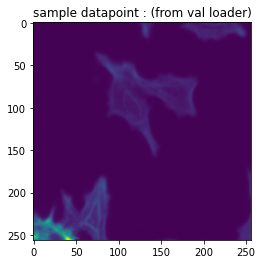

dataset value range :  0.003922564908862114 0.9450981616973877


In [22]:
trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= 2112)
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= True)

In [7]:
from modules.models.forward_H import modelH_class
from modules.models.forward_model import modelA_class


from modules.models.preprocess_H_weights import * #ifft_2d_with_fftshift_real
from modules.custom_activations import sigmoid_custom
from modules.kernels import *
from modules.psfs import *

device= cfg.GENERAL.device
print(f'device : {device}')


T= cfg.MODEL.MODEL_H.T
img_size= cfg.DATASET.img_size
H_weight_preprocess= eval(cfg.MODEL.MODEL_H.H_weight_preprocess)
initialization_bias= cfg.MODEL.MODEL_H.initialization_bias
H_activation= eval(cfg.MODEL.MODEL_H.H_activation)
H_init = cfg.MODEL.MODEL_H.H_init
enable_train= False
lambda_scale_factor=cfg.MODEL.MODEL_A.lambda_scale_factor
sPSF= eval(cfg.MODEL.MODEL_A.sPSF)
exPSF= eval(cfg.MODEL.MODEL_A.exPSF)
noise=cfg.MODEL.MODEL_A.noise
rotation_lambda=cfg.MODEL.MODEL_A.rotation_lambda
shift_lambda_real=cfg.MODEL.MODEL_A.shift_lambda_real
readnoise_std=cfg.MODEL.MODEL_A.readnoise_std

modelH = modelH_class(T=T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, 
                          device = device, 
                          initialization_bias=initialization_bias, 
                          activation = H_activation, init_method= H_init, 
                          enable_train=enable_train, lambda_scale_factor= lambda_scale_factor).to(device)

modelA= modelA_class(sPSF= sPSF.to(device), exPSF= exPSF.to(device), noise=noise, device = device, 
                        scale_factor=lambda_scale_factor, rotation_lambda=rotation_lambda, 
                        shift_lambda_real= shift_lambda_real,
                        readnoise_std= readnoise_std)

device : cuda:1


In [8]:
from modules.datasets import *
from modules.data_utils import return_dataloaders

total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112
dataset lenths : 3000 | 600 | 600


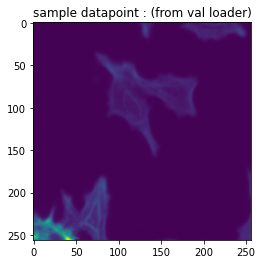

dataset value range :  0.003921568859368563 0.9450980424880981


In [9]:


get_dataset_func = bbbcHumanMCF7cellsW4
delta= 0
num_samples_train= cfg.DATASET.num_samples_train
num_samples_valtest= cfg.DATASET.num_samples_valtest
batch_size_train= cfg.DATASET.batch_size_train
batch_size_valtest= cfg.DATASET.batch_size_valtest

drop_last_val_test= False

trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= num_samples_valtest)    
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= drop_last_val_test, batch_size_valtest= batch_size_valtest)


In [10]:
dec_state_dict= {}
for k, v in model_details['decoder'].items():
    if 'F_lossfn' in k:continue
    dec_state_dict[k]= v

In [12]:
model_details.keys()

dict_keys(['cfg', 'epoch', 'm', 'decoder', 'decoder_upsample', 'model_H', 'losses_train', 'losses_val', 'metrics_train', 'metrics_val', 'opt_decoder_state_dict', 'opt_Ht_state_dict'])

In [11]:
decoder= swinIR_generative_decoder(f'{project_dir}/{other_opt_dir}', cfg, modelA, modelH)
decoder.load_state_dict(dec_state_dict)

NameError: name 'swinIR_generative_decoder' is not defined

In [65]:
def get_preds_decoder(decoder, X):
    decoder.feed_data({'m':8, 'H':X})
    decoder.test()
    X_hat = decoder.E
    Ht= decoder.Ht
    yt_down= decoder.yt_down

    return X_hat, Ht, yt_down

In [66]:
import torchvision
transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Grayscale(1),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0,), (1,))])
            
def whole2patch(whole_img, H, W, img_size): #whole_img: (H, W), patch_imgs: (b, 1, img_size, img_size)
    patch_imgs = whole_img.reshape(H//img_size, img_size, W//img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).unsqueeze(dim=1)
    return patch_imgs

def patch2whole(patch_imgs, H, W, img_size): # patch_imgs: (b, 1, img_size, img_size)
    out_recon= patch_imgs[:,0].reshape(H//img_size, W//img_size, img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2)
    return out_recon

In [67]:
import numpy as np

test_datasets= ['/home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val']

In [68]:
plt.imread(glob.glob('/home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val/*.png')[0]).shape

(256, 256)

In [69]:
'''

        plt.figure(figsize= (12,5))
        plt.subplot(1,2,1)
        plt.imshow(input_img, vmin=0,vmax=1)
        plt.subplot(1,2,2)
        plt.imshow(recon_img, vmin=0,vmax=1)
        plt.show()

        for _ in range(2):
            idx= np.random.randint(0, X.shape[0]-1)
            plt.figure(figsize= (6,6))
            plt.subplot(1,2,1)
            plt.imshow(X[idx, 0], vmin=0,vmax=1)
            plt.subplot(1,2,2)
            plt.imshow(X_hat[idx, 0], vmin=0,vmax=1)
            plt.show()
'''

'\n\n        plt.figure(figsize= (12,5))\n        plt.subplot(1,2,1)\n        plt.imshow(input_img, vmin=0,vmax=1)\n        plt.subplot(1,2,2)\n        plt.imshow(recon_img, vmin=0,vmax=1)\n        plt.show()\n\n        for _ in range(2):\n            idx= np.random.randint(0, X.shape[0]-1)\n            plt.figure(figsize= (6,6))\n            plt.subplot(1,2,1)\n            plt.imshow(X[idx, 0], vmin=0,vmax=1)\n            plt.subplot(1,2,2)\n            plt.imshow(X_hat[idx, 0], vmin=0,vmax=1)\n            plt.show()\n'

In [70]:
def pad_img(img, window_size, h_old, w_old): # input: img (A, B)
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img = torch.cat([img, torch.flip(img, [0])], 0)[:h_old + h_pad, :]
    img = torch.cat([img, torch.flip(img, [1])], 1)[:, :w_old + w_pad]

    return img

In [71]:
import torch
from torch.nn import functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from ignite.metrics import SSIM as SSIM_IGNITE
from ignite.metrics import PSNR

 
def ssim_ignite(X_hat, X, k= 11):
    metric = SSIM_IGNITE(data_range = 1.0, kernel_size= (k,k))
    metric.update((X_hat, X))
    return metric.compute().item()

def psnr_ignite(X_hat, X):
    metric = PSNR(data_range=1.0) #(data_range= 235- 16= 219) ->  https://scikit-image.org/docs/dev/api/skimage.color.html#rgb2ycbcr 
    metric.update((X_hat, X))
    return metric.compute().item()

In [72]:
len(glob.glob(f'{dataset_dir}/*.png'))

2112

In [73]:
import matplotlib.pyplot as plt
import glob

import torch
import cv2
import util
import numpy as np
from PIL import Image
from collections import OrderedDict

device= 'cuda:0'
window_size= 64
scale= 4


test_results = OrderedDict()
test_results['psnr'] = []
test_results['ssim'] = []
test_results['psnr_y'] = []
test_results['ssim_y'] = []
test_results['psnr_b'] = []


for border in [0, scale]:
    print('\n')
    for dataset_dir in test_datasets:

        i=0
        for img_dir in glob.glob(f'{dataset_dir}/*.png')[:100]:
            if i>4:break

            input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
            H, W = input_img.shape
            input_img_padded = pad_img(input_img, window_size, H, W)
            H_new, W_new = input_img_padded.shape

            X= whole2patch(input_img_padded, H_new, W_new, img_size)
            X_hat, Ht, yt_down = get_preds_decoder(decoder, X)
            X_hat, Ht, yt_down= X_hat.detach().cpu(), Ht.detach().cpu(), yt_down.detach().cpu()

            recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
            recon_img= recon_img_padded[:H, :W]

            #### 
            output = (recon_img.unsqueeze(dim=2).cpu().detach().numpy() * 255.0).astype('uint8') #shape : HWC
            img_gt = (input_img.unsqueeze(dim=2).cpu().detach().numpy() * 255.0).astype('uint8') #shape : HWC
            
            psnr = util.calculate_psnr(output, img_gt, crop_border=border)
            ssim = util.calculate_ssim(output, img_gt, crop_border=border)

            test_results['psnr'].append(psnr)
            test_results['ssim'].append(ssim)
            if img_gt.ndim == 3:  # RGB image
                psnr_y = util.calculate_psnr(output, img_gt, crop_border=border, test_y_channel=True)
                ssim_y = util.calculate_ssim(output, img_gt, crop_border=border, test_y_channel=True)
                test_results['psnr_y'].append(psnr_y)
                test_results['ssim_y'].append(ssim_y)
                
        # summarize psnr/ssim
        if img_gt is not None:
            ave_psnr = sum(test_results['psnr']) / len(test_results['psnr'])
            ave_ssim = sum(test_results['ssim']) / len(test_results['ssim'])

            print(f'border = {border}  -->  Average PSNR/SSIM(RGB): {np.round(ave_psnr, 2)} dB; {np.round(ave_ssim, 4)}')
            #print('\n-- Average PSNR/SSIM(RGB): {:.2f} dB; {:.4f}'.format(ave_psnr, ave_ssim))



border = 0  -->  Average PSNR/SSIM(RGB): 43.2 dB; 0.9279


border = 4  -->  Average PSNR/SSIM(RGB): 43.21 dB; 0.9279


total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/train -> 206976
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/val -> 2112
total images found in: /home/udith/udith_works/datasets/bbbcHumanMCF7cells/preprocessed/w4/test -> 2112
dataset lenths : 100 | 2112 | 2112


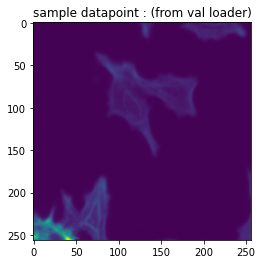

dataset value range :  0.003921568859368563 0.9450980424880981


In [81]:
get_dataset_func = bbbcHumanMCF7cellsW4
delta= 0
num_samples_train= 100
num_samples_valtest= 2112
batch_size_train= 10
batch_size_valtest= 32

drop_last_val_test= False

trainset, valset, testset = get_dataset_func(img_size= 256, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= num_samples_valtest)    
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= drop_last_val_test, batch_size_valtest= batch_size_valtest)

for x, y in val_loader:
    pass

In [ ]:
import cv2
for idx, (x, y) in enumerate(val_loader):
    #print(x.shape, y)
    grid_img = torchvision.utils.make_grid(x, nrow=8)
    plt.figure(figsize= (10, 5))
    plt.imshow(cv2.cvtColor(grid_img.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
    plt.show()

In [ ]:
plt.imshow(x[0])

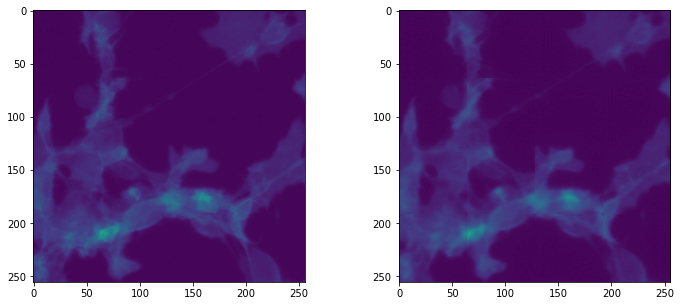

In [37]:
dataset_dir = test_datasets[0]
img_dir = glob.glob(f'{dataset_dir}/*.png')[10]

input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
H, W = input_img.shape
input_img_padded = pad_img(input_img, window_size, H, W)
H_new, W_new = input_img_padded.shape

X= whole2patch(input_img_padded, H_new, W_new, img_size)
X_hat, Ht, yt_down = get_preds_decoder(decoder, X)
X_hat, Ht, yt_down= X_hat.detach().cpu(), Ht.detach().cpu(), yt_down.detach().cpu()

recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
recon_img= recon_img_padded[:H, :W]


plt.figure(figsize= (12,5))
plt.subplot(1,2,1)
plt.imshow(input_img, vmin=0,vmax=1)
plt.subplot(1,2,2)
plt.imshow(recon_img, vmin=0,vmax=1)
plt.show()


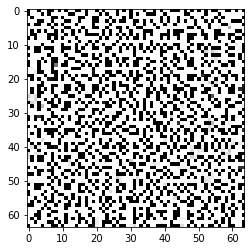

In [42]:
plt.imshow(Ht[0, 0].cpu(), cmap= 'gray' )